In [1]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import local_models.loggin
import local_models.TLS_models
import local_models.algorithms
import local_models.linear_projections
import sklearn.gaussian_process as gp
import patched_gpr


logger = logging.getLogger(__name__)

np.random.seed(1)
reload(local_models.local_models)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*3)
import cycler
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', CB_color_cycle)

In [3]:
project_dir = "../data/local_gpr_7"
os.makedirs(project_dir, exist_ok=1)

In [4]:
HZ=1

In [5]:
def clear(fig, axs):
    for ax in axs:
        ax.clear()
    fig.clear()
    plt.close(fig)
    plt.close("all")

In [6]:
def adjust_ax_labels(axs, rng, n_ticks=8, hz=250):
    try:
        axs_iterator = iter(axs)
    except TypeError as te:
        axs_iterator = iter([axs])
    for ax in axs_iterator:
        ax.axis("off")
    ax.axis("on")
    x_ticks = np.linspace(rng[0],rng[1],n_ticks)
    x_tick_labels = x_ticks/hz
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(list(map(lambda x: "{:.01f}".format(x), x_tick_labels)))
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False) 

In [7]:
def clear(fig, axs):
    try:
        for ax in axs:
            ax.clear()
    except:
        axs.clear()
    fig.clear()
    plt.close(fig)
    plt.close("all")
    
def plt_gpr_params(X, y, gpr_X, gpr_params, chg_ptses, kernel, filename, hz=HZ, display=False):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    adjust_ax_labels(axs,(np.min(X), np.max(X)),hz=HZ)
    artists = []
    extra_dims = []
    colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for var in range(gpr_params.shape[1]):
        c = next(colors)
        ar = axs[0].plot(gpr_X, gpr_params[:,var],c=c)
        artists.append(ar[0])
    for i, chg_pts in enumerate(chg_ptses):
        if i==0:
            extra_dims.append("true change points")
        elif i==1:
            extra_dims.append("pred change points")
        c = next(colors)
        for chg_pt in chg_pts:
            for ax in axs:
                ar = ax.axvline(chg_pt,c=c,lw=2,linestyle=(i*5,(5,5)))
        artists.append(ar)
    c = next(colors)
    ar = axs[1].plot(X, y, c=c)
    extra_dims.append("raw data")
    artists.append(ar[0])
    axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])) + extra_dims,loc="lower left")
    if filename:
        plt.savefig(filename)
    if not display:
        clear(fig, axs)
    return fig, axs

In [8]:
class GPRNeighborFixedMixt(patched_gpr.GaussianProcessRegressor):
    def fit(self, X,y,sample_weight=None, **kwargs):
        beta0 = None
        if "beta0" in kwargs:
            beta0 = kwargs["beta0"]
            del kwargs["beta0"]
        the_model = super().fit(X,y,sample_weight, **kwargs)
        if beta0 is not None:
            beta0_model = sklearn.base.clone(self)
            beta0_model.kernel = self.kernel.clone_with_theta(beta0)
            beta0_model.fit(X,y,sample_weight,**kwargs)
            if beta0_model.log_marginal_likelihood_value_ < the_model.log_marginal_likelihood_value_:
                old_restart = the_model.n_restarts_optimizer
                the_model.n_restarts_optimizer = 400
                the_model = the_model.fit(X,y,sample_weight, **kwargs)
                the_model.n_restarts_optimizer = old_restart

        self.coef_ = the_model.kernel_.theta
        self.intercept_ = np.empty((0,))
        return the_model

In [9]:
class LogGaussian(local_models.local_models.UnaryKernel):
    def __call__(self, x):
        x = self.apply_bandwidth(x)
        return -x**2/2
    def d(self, x):
        x = self.apply_bandwidth(x)
        return -x

In [10]:
def soft_bound(kernel,theta,priors=None):
    if priors is None:
        priors = []
        bs = np.abs(np.diff(kernel.bounds, axis=1))/2
        for i,bound in enumerate(kernel.bounds):
            priors.append(LogGaussian(bs[i]+0.5))
    probs = np.empty(theta.shape)
    d_probs = np.empty(theta.shape)
    for i,bound in enumerate(kernel.bounds):
        u = theta - np.mean(bound)
        probs[i] = priors[i](u[i])
        d_probs[i] = priors[i].d(u[i])
    return np.sum(probs), d_probs

In [11]:
class GPR(patched_gpr.GaussianProcessRegressor):
    def fit(self, X,y,sample_weight=None, **kwargs):
        beta0 = None
        if "beta0" in kwargs:
            self.kernel.theta = kwargs["beta0"]
            del kwargs["beta0"]
        sample_weight = sample_weight/np.sum(sample_weight)*sample_weight.shape[0] #sums to n
        the_model = super().fit(X,y,sample_weight, **kwargs)
        self.coef_ = the_model.kernel_.theta
        self.intercept_ = np.empty((0,))
        return the_model
        
class GPRSoftBounds(GPR):
    def __init__(self, kernel=None, alpha=1e-10,
                 optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0,
                 normalize_y=False, copy_X_train=True, random_state=None, priors=None):
        self.priors = priors
        super().__init__(kernel=kernel, alpha=alpha,
                 optimizer=optimizer, n_restarts_optimizer=n_restarts_optimizer,
                 normalize_y=normalize_y, copy_X_train=copy_X_train, random_state=random_state,)
    def log_marginal_likelihood(self, theta=None, eval_gradient=False, sample_weight=None):
        lml = super().log_marginal_likelihood(theta, eval_gradient, sample_weight)
        if theta is None:
            return lml
        if eval_gradient:
            lml, grad = lml
        prob, d_probs = soft_bound(self.kernel_, theta, self.priors)
        #print(lml, prob)
        lml += prob
        if eval_gradient:
            grad += d_probs
            return lml, grad
        else:
            return lml

## Variable Noise

In [12]:
X = np.linspace(1,1000,1000).reshape((-1,1))
y = 10*np.sin(X/50)
y[:450,0] += np.random.normal(0,1,450)
y[450:550,0] += np.random.normal(0,5,100)
y[550:,0] += np.random.normal(0,1,450)

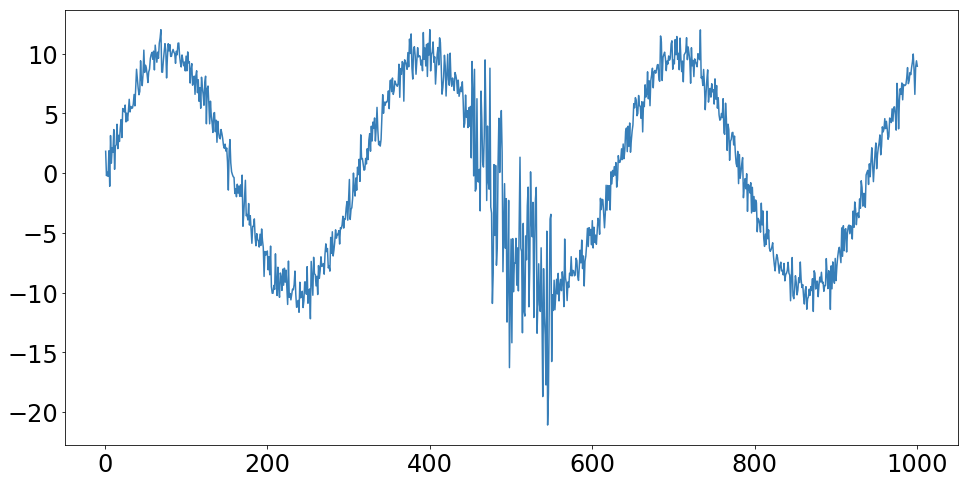

In [13]:
plt.plot(X,y)
plt.show()

In [14]:
kernel = np.sum((
    #gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,100]), 
    np.prod((
        gp.kernels.ConstantKernel(constant_value=10, constant_value_bounds=[1e-10,1e10]),
        np.sum((
            gp.kernels.RBF(length_scale=10., length_scale_bounds=[1e-10,1e10]),
            #gp.kernels.WhiteKernel(noise_level=-1, noise_level_bounds="fixed")
        ))
    )),
    gp.kernels.WhiteKernel(noise_level=20, noise_level_bounds=[1e-9,1e10])
))

In [15]:
kernel(np.array([[1],[2]]), eval_gradient=True)[1][:,:,0]

array([[10.        ,  9.95012479],
       [ 9.95012479, 10.        ]])

In [16]:
exemplar_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0, optimizer=None)

In [17]:
bandwidth = 120
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

In [18]:
exemplar_rng = (bandwidth, 3*(bandwidth-1))
exemplar_X = X[slice(*exemplar_rng)]
exemplar_y = y[slice(*exemplar_rng)]
waits = lm_kernel(np.abs(exemplar_X - np.mean(exemplar_X)))[:,0]
waits /= np.sum(waits) 
waits *= exemplar_X.shape[0]
exemplar_regressor.fit(
    exemplar_X, 
    exemplar_y, 
    sample_weight = waits
)
exemplar_regressor.log_marginal_likelihood(theta=kernel.theta, eval_gradient=True)

(-677.8540101080589, array([   9.20536427,   15.99303606, -110.66340522]))

In [19]:
kernel.theta

array([2.30258509, 2.30258509, 2.99573227])

In [20]:
exemplar_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)

In [21]:
exemplar_regressor.fit(
    exemplar_X, 
    exemplar_y, 
    sample_weight = waits
)

GPR(alpha=0, copy_X_train=True,
    kernel=3.16**2 * RBF(length_scale=10) + WhiteKernel(noise_level=20),
    n_restarts_optimizer=400, normalize_y=True, optimizer='fmin_l_bfgs_b',
    random_state=None)

In [22]:
np.exp(exemplar_regressor.kernel_.theta)

array([ 1.22782681, 37.48031956,  3.18716525])

In [23]:
exemplar_regressor.log_marginal_likelihood(theta=exemplar_regressor.kernel_.theta, eval_gradient=True)

(-526.2167699913468, array([ 29.02833444,  -7.17307988, -57.29524461]))

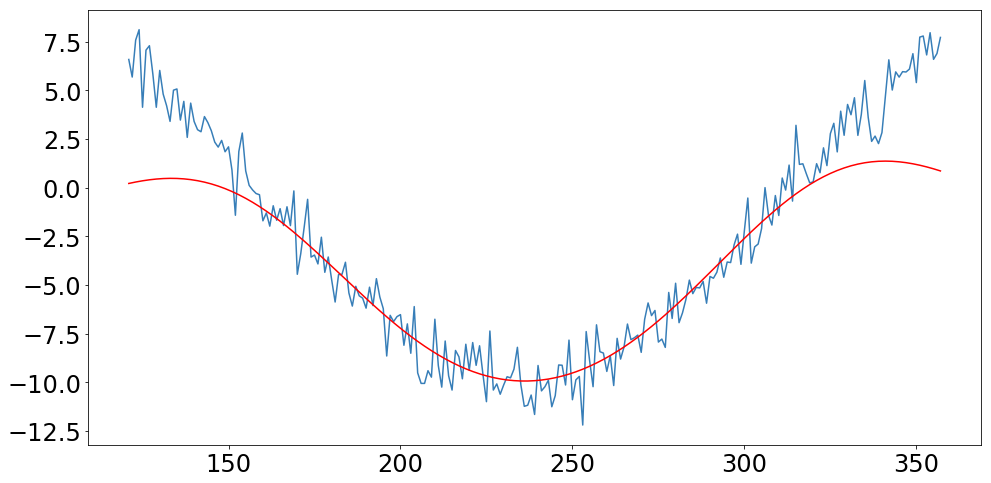

In [24]:
plt.plot(exemplar_X,exemplar_y)
plt.plot(exemplar_X,exemplar_regressor.predict(exemplar_X),c='r')
plt.savefig(os.path.join(project_dir, "exemplar_variable_noise_b{:07.02f}_rng{}.png".format(bandwidth, str(exemplar_rng))))

In [25]:
kernel = np.sum((
    #gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,100]), 
    np.prod((
        gp.kernels.ConstantKernel(
            constant_value=exemplar_regressor.kernel_.k1.k1.constant_value, 
            constant_value_bounds=[
                exemplar_regressor.kernel_.k1.k1.constant_value/1e2,
                exemplar_regressor.kernel_.k1.k1.constant_value*1e2
            ]),
        np.sum((
            gp.kernels.RBF(
                length_scale=exemplar_regressor.kernel_.k1.k2.length_scale, 
                length_scale_bounds=[
                    exemplar_regressor.kernel_.k1.k2.length_scale/1e2,
                    exemplar_regressor.kernel_.k1.k2.length_scale*1e2
                ]),
            #gp.kernels.WhiteKernel(
            #    noise_level=-1,
            #    noise_level_bounds="fixed")
        ))
    )),
    gp.kernels.WhiteKernel(
        noise_level=exemplar_regressor.kernel_.k2.noise_level, 
        noise_level_bounds=[
            exemplar_regressor.kernel_.k2.noise_level*1e-2,
            exemplar_regressor.kernel_.k2.noise_level*1e2
        ]),
    #gp.kernels.WhiteKernel(
    #    noise_level=exemplar_regressor.kernel_.k2.noise_level, 
    #    noise_level_bounds=[
    #        exemplar_regressor.kernel_.k2.noise_level/1e2,
    #        exemplar_regressor.kernel_.k2.noise_level*1e2
    #    ]),
))

In [26]:
regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
gpr_models = local_models.local_models.LocalModels(regressor)
gpr_models.fit(X,y)

In [28]:
gpr_params = gpr_models.transform(X,r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel, neighbor_beta0s=False, batch_size=X.shape[0])

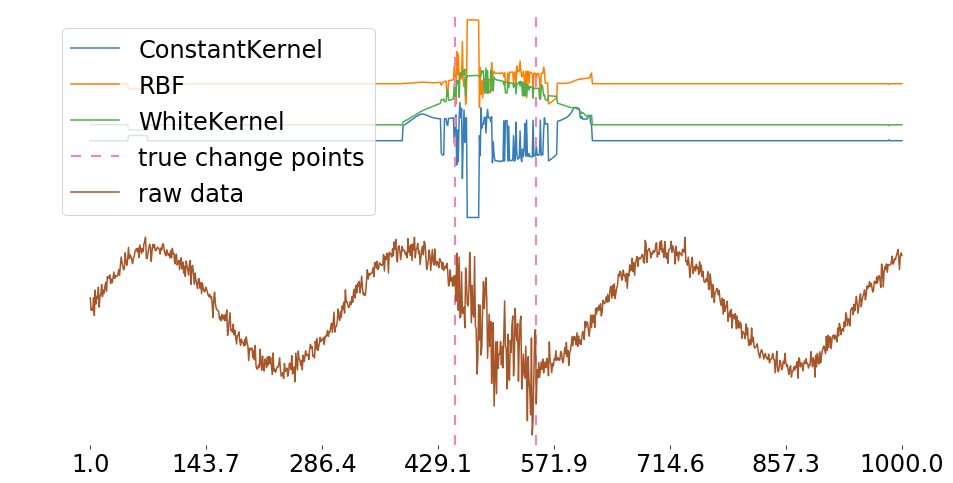

In [30]:
fig, axs = plt_gpr_params(
    X,y,
    X,gpr_params,
    [[450,550]],
    kernel,
    os.path.join(project_dir, 
    "all_parms_variable_noise_gpr_k{}_b{:07.02f}.png".format(
        "_".join(list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims]))),
        bandwidth,
    )),
    display=True
)

In [31]:
FRESH=True
dat_dir = os.path.join(project_dir, "dat_variable_noise_01")
os.makedirs(dat_dir, exist_ok=1)

In [32]:
parms = []
noise_seeds = [1e-9,1e-6,1e-3,1,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
grid_seeds = np.mgrid[-1:6:7j,-1:6:7j]

In [33]:
grid_seeds = np.exp(grid_seeds.T.reshape(np.product(grid_seeds.shape[1:]),2))

In [34]:
grid_seeds = np.concatenate((grid_seeds,np.array((1e-5,1e-5)).reshape(1,-1)),axis=0)

In [35]:
grid_seeds = np.concatenate((grid_seeds,np.array((1e-5,1e10)).reshape(1,-1)),axis=0)

In [36]:
grid_seeds = np.concatenate((grid_seeds,np.array((1e10,1e-5)).reshape(1,-1)),axis=0)

In [ ]:
if FRESH:
    for i, grid_seed in enumerate(grid_seeds[len(parms):]):
        kernel = np.sum((
            #gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,100]), 
            np.prod((
                gp.kernels.ConstantKernel(
                    constant_value=grid_seed[0], 
                    constant_value_bounds="fixed"),
                gp.kernels.RBF(
                    length_scale=grid_seed[1], 
                    length_scale_bounds="fixed")
            )),
            gp.kernels.WhiteKernel(
                noise_level=np.exp(grid_seed[0]), noise_level_bounds=[1e-10,1e10])
        ))
        regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        gpr_models = local_models.local_models.LocalModels(regressor)
        gpr_models.fit(X,y)
        local_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
        gpr_params = gpr_models.transform(X,r=local_kernel.support_radius()-1, weighted=True, kernel=local_kernel, neighbor_beta0s=False, batch_size=X.shape[0])
        parms.append(gpr_params)

In [ ]:
def fit_meanshift(gpr_paramses, kernel):
    mean_regressor = local_models.TLS_models.LinearODR_mD(0)
    mean_models = local_models.local_models.LocalModels(mean_regressor)
    mean_models.fit(gpr_paramses)
    for i, (dat, report) in enumerate(local_models.algorithms.local_tls_shift_till_convergence(
                mean_models, gpr_paramses, kernel=kernel, report=True)):
        if not i%100:
            #print(report)
            pass
    return dat
    
def cleanup_meanshift(meanshifted_data, tol=1e-7): 
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(meanshifted_data)
    bins = bt.query_radius(meanshifted_data, r=tol)
    cleanuped = np.empty(meanshifted_data.shape)
    for i, the_bin in enumerate(bins):
        cleanuped[i] = np.mean(meanshifted_data[the_bin], axis=0)
    return cleanuped
    
def pick_optimal_meanshift_bandwidth(initial_bandwidths, gpr_paramses, iterations=7):
    #go middle of the road to get two clusters.
    #i.e. find the minimum bandwidth giving 3, the max giving 1, then take their average
    print(iterations)
    checked_bandwidths = []
    given_n_clusters = []
    if iterations == 0:
        return checked_bandwidths, given_n_clusters
    for bandwidth in initial_bandwidths:
        ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
        fitted_meanshift = fit_meanshift(gpr_paramses, ms_kernel)
        fitted_meanshift = cleanup_meanshift(fitted_meanshift)
        observed_clusters = np.unique(fitted_meanshift, axis=0).shape[0]
        checked_bandwidths.append(bandwidth)
        given_n_clusters.append(observed_clusters)
    #get half of the ones, and half of the twos:
    the_ones = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==1]
    the_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==2]
    the_more_than_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]>2]
    median_the_ones = np.median(the_ones) if the_ones else max(initial_bandwidths)*2
    median_the_more_than_twos = np.median(the_more_than_twos) if the_more_than_twos else min(initial_bandwidths)/2
    median_the_twos = np.median(the_twos) if the_twos else np.mean([median_the_ones, median_the_more_than_twos])
    sub_checked, sub_n_clusters = pick_optimal_meanshift_bandwidth(
        np.concatenate((
            np.linspace(median_the_more_than_twos, median_the_twos, len(initial_bandwidths)),
            np.linspace(median_the_twos, median_the_ones, len(initial_bandwidths))
        )),
        gpr_paramses,
        iterations - 1
    )
    return checked_bandwidths + sub_checked, given_n_clusters + sub_n_clusters 

In [ ]:
def mean_d_half_neighbors(dat):
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(dat)
    dz, iz = bt.query(dat, k=int(dat.shape[0]/2), return_distance=True, sort_results=True)
    return np.mean([dz[i][-1] for i in range(len(dz))])

In [ ]:
def gprify(X, y, gpr_kernel, bandwidth):
    lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
    exemplar_regressor = GPR(kernel=gpr_kernel, normalize_y=True, n_restarts_optimizer=7, alpha=0)
    exemplar_rng = (int(bandwidth), 2*int(bandwidth)-2)
    exemplar_X = X[slice(*exemplar_rng)]
    exemplar_y = y[slice(*exemplar_rng)]
    exemplar_regressor.fit(
        exemplar_X, 
        exemplar_y, 
        sample_weight = lm_kernel(np.abs(exemplar_X - np.mean(exemplar_X)))[:,0])
        
    regressor = GPR(kernel=exemplar_regressor.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
    gpr_models = local_models.local_models.LocalModels(regressor)
    gpr_models.fit(X,y)
    gpr_params = gpr_models.transform(X, r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel, neighbor_beta0s=False, batch_size=X.shape[0])
    return gpr_params

def clusterify(X, iterations=5):
    halfspace_bandwidth = mean_d_half_neighbors(X)
    bs, ns = pick_optimal_meanshift_bandwidth(
        [halfspace_bandwidth/2, halfspace_bandwidth/4, halfspace_bandwidth/8], 
        X, iterations=iterations)
    if 2 in ns:
        optimal_meanshift_bandwidth = np.median([bs[i] for i in range(len(bs)) if ns[i] ==2])
    else:
        optimal_meanshift_bandwidth = np.median(bs)
    ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=optimal_meanshift_bandwidth)
    meanshifted = fit_meanshift(X, ms_kernel)
    meanshifted = cleanup_meanshift(meanshifted)
    return optimal_meanshift_bandwidth, meanshifted

def get_clusterified_change_points(X, clusterified_data):
    return X[
        np.nonzero(
            np.diff(
                np.linalg.norm(clusterified_data, axis=1), 
                axis=0))]
    
def compare_change_points(y_pred, y_true):
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(y_true)
    dz,iz = bt.query(y_pred, k=1, return_distance=True)
    return np.sum(dz)
    

In [ ]:
def pick_optimal_gpr_bandwidth_for_changepoint_detection(
    X, y, gpr_kernel, bounding_bandwidths, observed_changepoints, 
    given_evaluations_at_bounding_bandwidths = [None,None], 
    given_optimal_meanshift_bandwidths = [None, None],
    given_optimal_meanshifts = [None, None],
    given_optimal_gpr_paramses = [None, None],
    iterations=7, meanshift_iterations=5):
    #get gpr params at each of the bounding bandwidths
    #pick_optimal_meanshift_bandwidth
    #compare each change point with nearest observed, this is the loss.
    #rinse and repeat at the midpoint and the lowest observed loss endpoint... (binary search)
    print(iterations)
    if iterations == 0:
        return [(
            bounding_bandwidths[i], 
            given_optimal_meanshift_bandwidths[i],
            given_optimal_meanshifts[i],
            given_optimal_gpr_paramses[i])
            for i in range(2) if given_evaluations_at_bounding_bandwidths[i] is not None
        ][0]
        
    evaluations_at_bounding_bandwidths = [None, None]
    optimal_meanshift_bandwidths = [None, None]
    optimal_meanshifts = [None, None]
    optimal_gpr_paramses = [None, None]
    for i, bandwidth in enumerate(bounding_bandwidths):
        if given_evaluations_at_bounding_bandwidths[i] is not None:
            evaluations_at_bounding_bandwidths[i] = given_evaluations_at_bounding_bandwidths[i]
            optimal_meanshift_bandwidths[i] = given_optimal_meanshift_bandwidths[i]
            optimal_meanshifts[i] = given_optimal_meanshifts[i]
            optimal_gpr_paramses[i] = given_optimal_gpr_paramses[i]
        else:
            gpr_params = gprify(X, y, gpr_kernel, bandwidth)
            optimal_meanshift_bandwidth, clusterified = clusterify(gpr_params, iterations=meanshift_iterations)
            changepts = get_clusterified_change_points(X, clusterified).reshape(-1,1)
            evaluations_at_bounding_bandwidths[i] = compare_change_points(changepts, observed_changepoints)
            optimal_meanshift_bandwidths[i] = optimal_meanshift_bandwidth
            optimal_meanshifts[i] = clusterified
            optimal_gpr_paramses[i] = gpr_params
    print("done iterating")
    best_bounding_bandwidth = np.argmin(evaluations_at_bounding_bandwidths)
    new_bounding_bandwidths = sorted([bounding_bandwidths[best_bounding_bandwidth], np.mean(bounding_bandwidths)])
    given_evaluations_at_bounding_bandwidths = [None, None]
    given_evaluations_at_bounding_bandwidths[best_bounding_bandwidth] = evaluations_at_bounding_bandwidths[best_bounding_bandwidth]
    given_optimal_meanshift_bandwidths = [None, None]
    given_optimal_meanshift_bandwidths[best_bounding_bandwidth] = optimal_meanshift_bandwidths[best_bounding_bandwidth]
    given_optimal_meanshifts = [None, None]
    given_optimal_meanshifts[best_bounding_bandwidth] = optimal_meanshifts[best_bounding_bandwidth]
    given_optimal_gpr_paramses = [None, None]
    given_optimal_gpr_paramses[best_bounding_bandwidth] = optimal_gpr_paramses[best_bounding_bandwidth]
    return pick_optimal_gpr_bandwidth_for_changepoint_detection(
        X, y, gpr_kernel, new_bounding_bandwidths, observed_changepoints,
        given_evaluations_at_bounding_bandwidths,
        given_optimal_meanshift_bandwidths,
        given_optimal_meanshifts,
        given_optimal_gpr_paramses,
        iterations=iterations-1, meanshift_iterations=meanshift_iterations)

In [ ]:
for i,parm in enumerate(parms):
    fig, axs = plt_gpr_params(
        X,y,
        X,parm,
        [[450,550]],
        kernel,
        os.path.join(project_dir, 
        "variable_noise_gpr_k{}_b{:07.02f}_c{:010.02f}_r{:010.02f}_w{:010.02f}.png".format(
            "_".join(list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims]))),
            bandwidth,
            grid_seeds[i,0],
            grid_seeds[i,1],
            1)),
        display=True
        )
    axs[0].set_title(str(grid_seeds[i]))

In [ ]:
regressor = GPRNeighborFixedMixt(kernel=exemplar_regressor.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
gpr_models = local_models.local_models.LocalModels(regressor)
gpr_models.fit(X,y)
local_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
gpr_params = gpr_models.transform(X,r=local_kernel.support_radius()-1, weighted=True, kernel=local_kernel, neighbor_beta0s=True, batch_size=X.shape[0])

In [ ]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,(np.min(X)-1, np.max(X)),hz=1,n_ticks=11)
artists = []
colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
for col in range(gpr_params.shape[1]):
    c = next(colors)
    ar = axs[0].plot(X, gpr_params[:,col],c=c)
    #axs[1].plot(X, opt_meanshifts[:,col],c=c)
    artists.append(ar[0])
ar = axs[1].plot(X,y,c=next(colors))
artists.append(ar[0])
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(exemplar_regressor.kernel_) if k.n_dims])) + ["data"],loc="lower left")
plt.savefig(os.path.join(project_dir, "mixed_neighborbeta0_globaloptimum.png"))

In [391]:
FRACS=2**np.arange(20)
FRACS

array([     1,      2,      4,      8,     16,     32,     64,    128,
          256,    512,   1024,   2048,   4096,   8192,  16384,  32768,
        65536, 131072, 262144, 524288])

In [393]:
frac_gpr_paramses = []
for frac in FRACS:
    priors = []
    bs = np.abs(np.diff(kernel.bounds, axis=1))/2
    for i,bound in enumerate(kernel.bounds):
        priors.append(LogGaussian(bs[i]/frac))

    regressor = GPRSoftBounds(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0, priors=priors)
    gpr_models = local_models.local_models.LocalModels(regressor)
    gpr_models.fit(X,y)
    local_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
    gpr_params, the_models = gpr_models.transform(X,r=local_kernel.support_radius()-1, weighted=True, kernel=local_kernel, neighbor_beta0s=True, batch_size=X.shape[0], return_models=True)
    frac_gpr_paramses.append(gpr_params)

In [388]:
def normalize(x):
    return (x-np.min(x))/np.ptp(x)

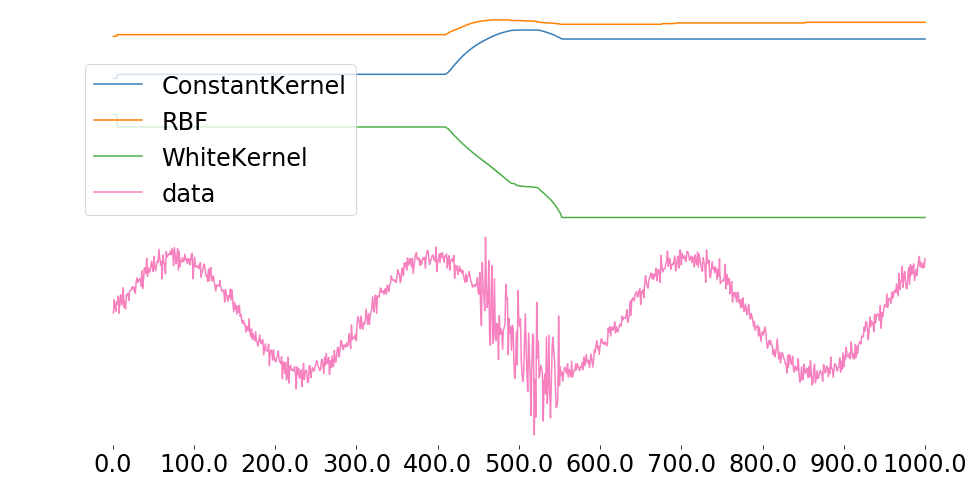

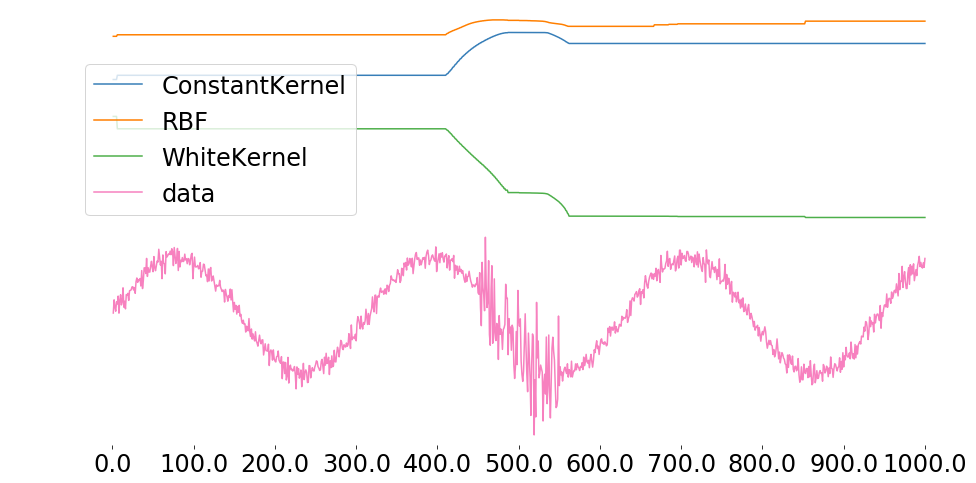

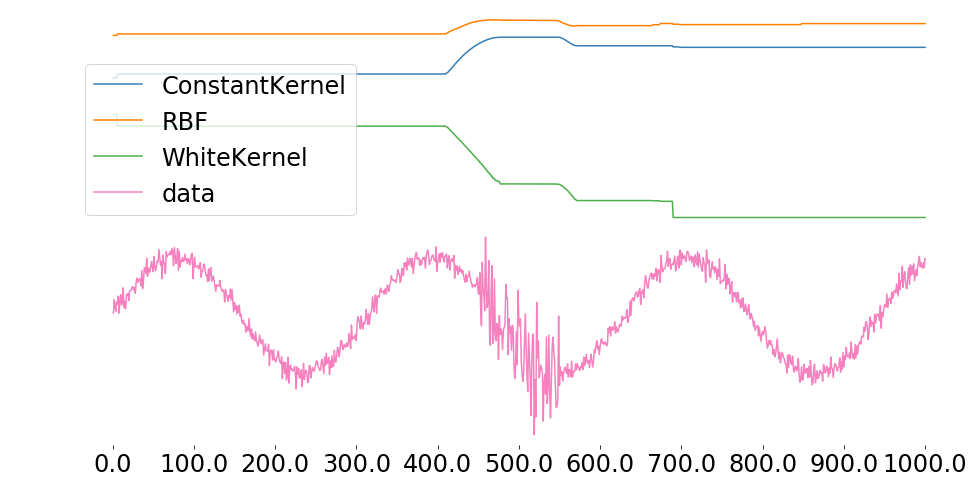

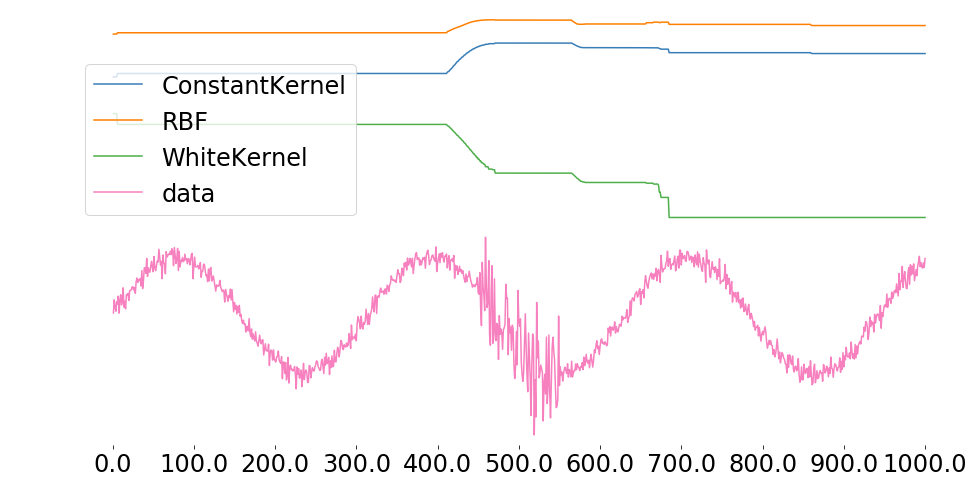

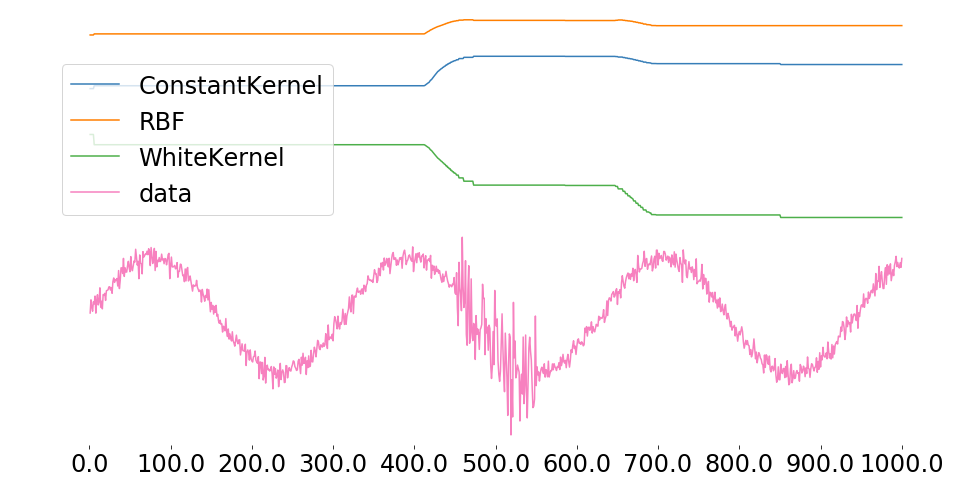

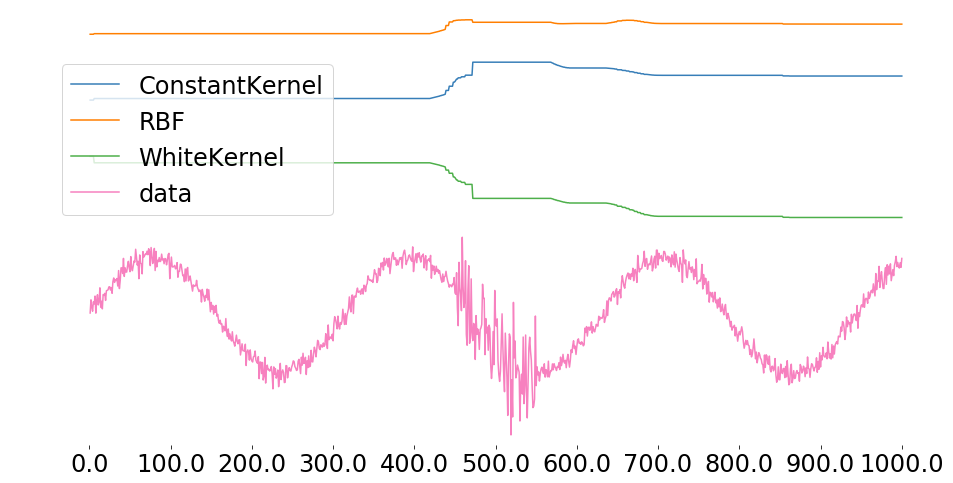

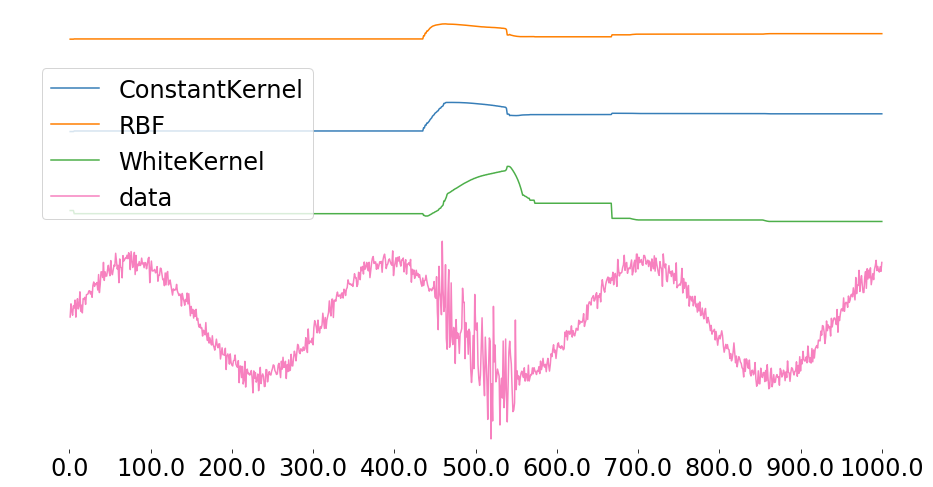

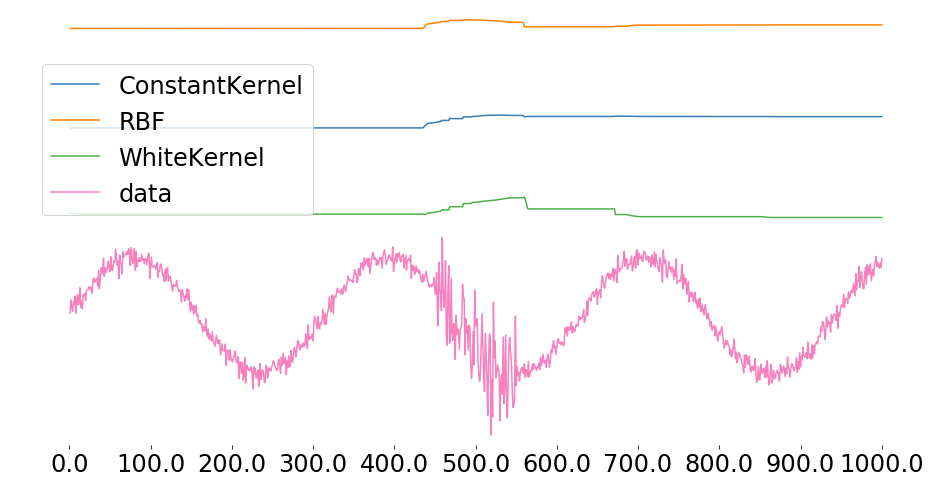

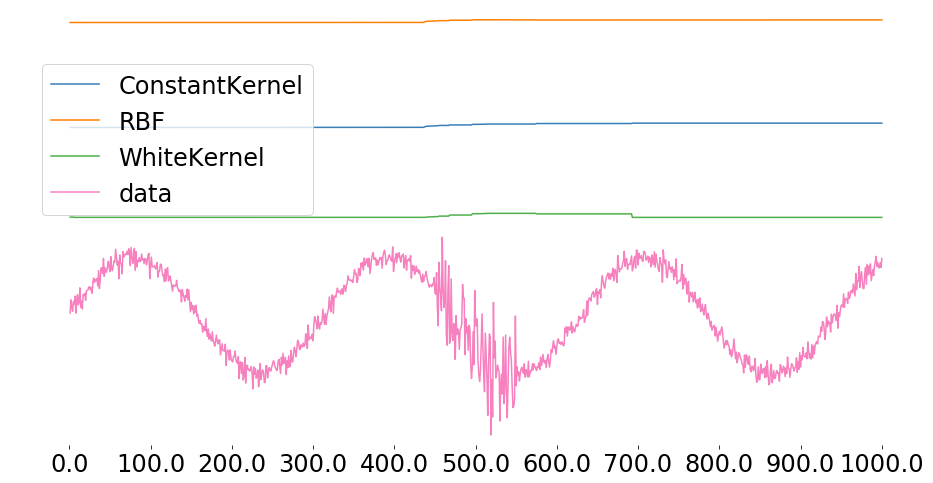

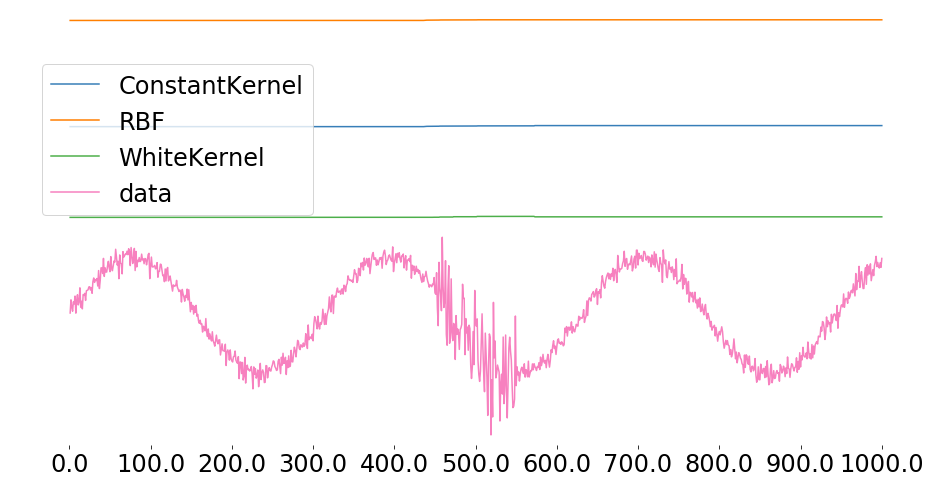

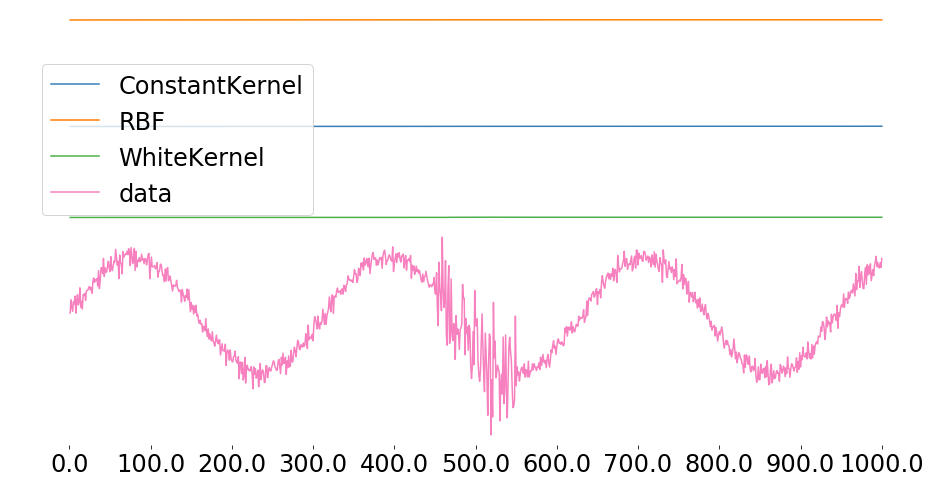

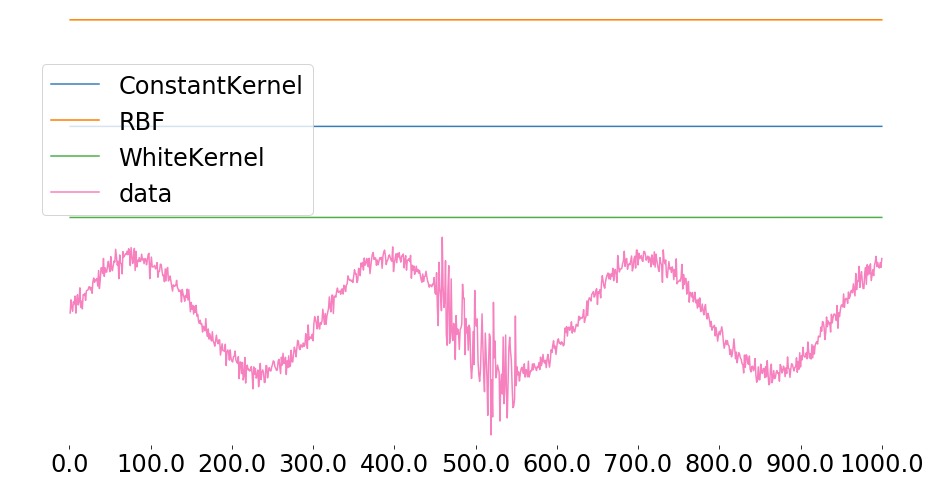

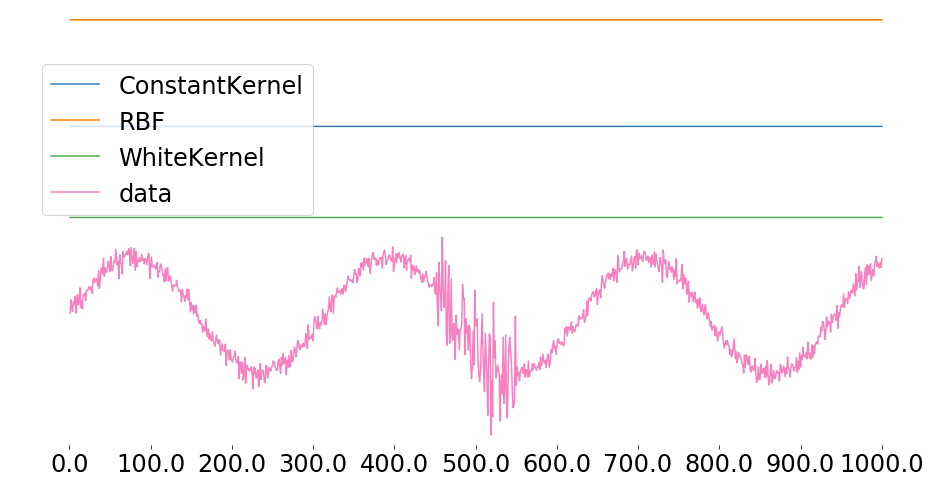

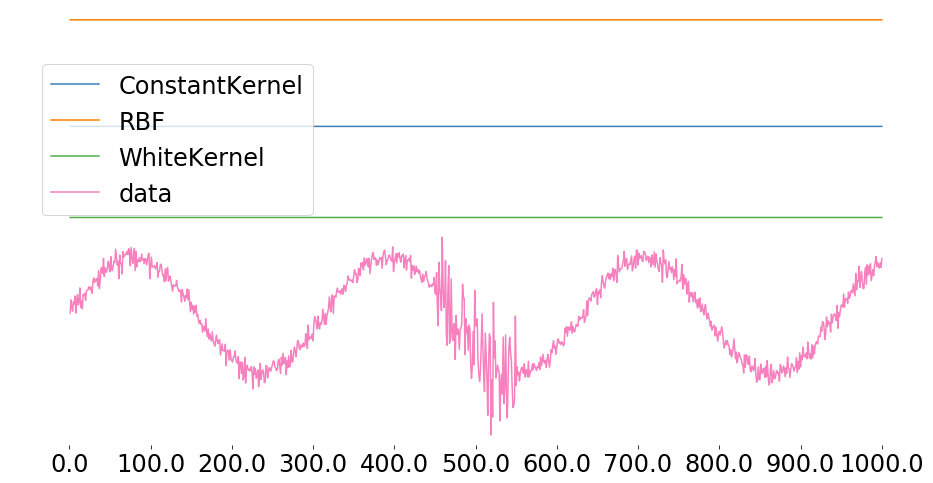

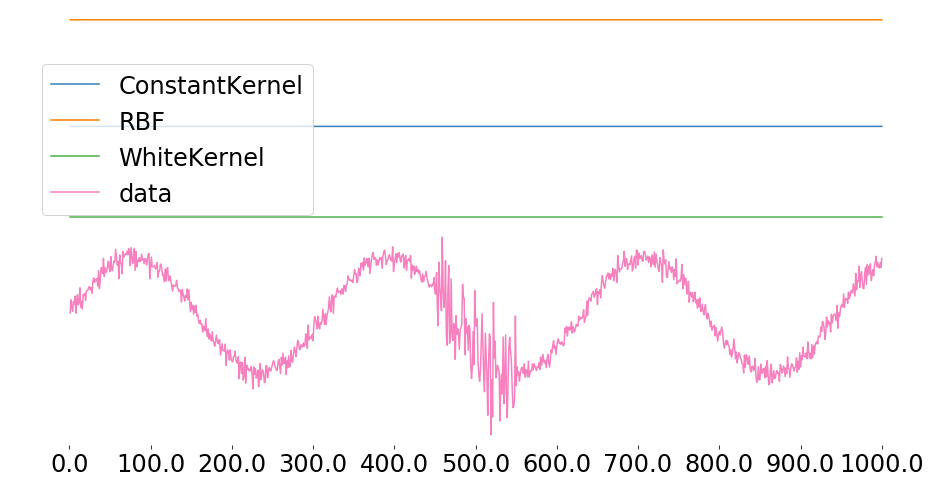

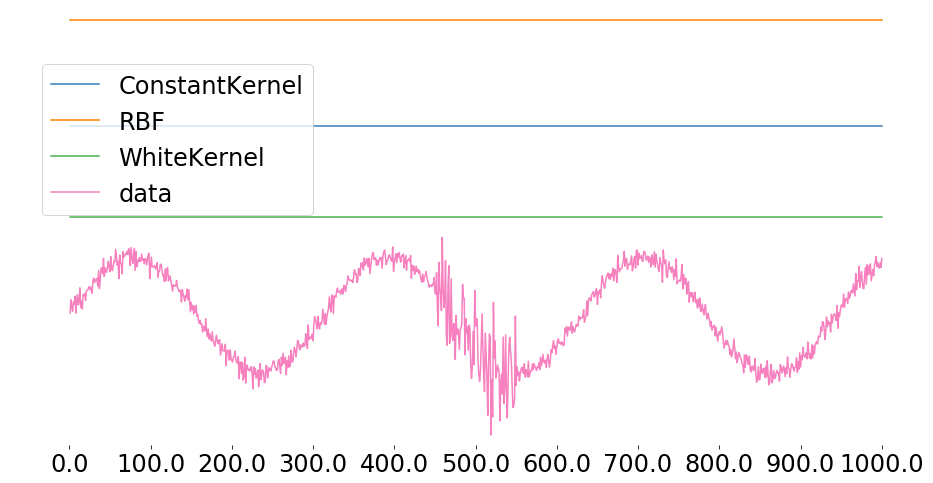

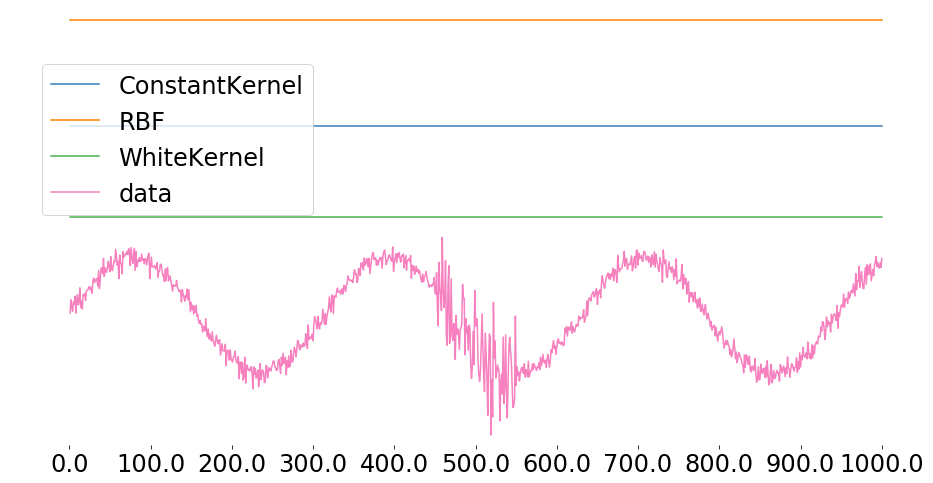

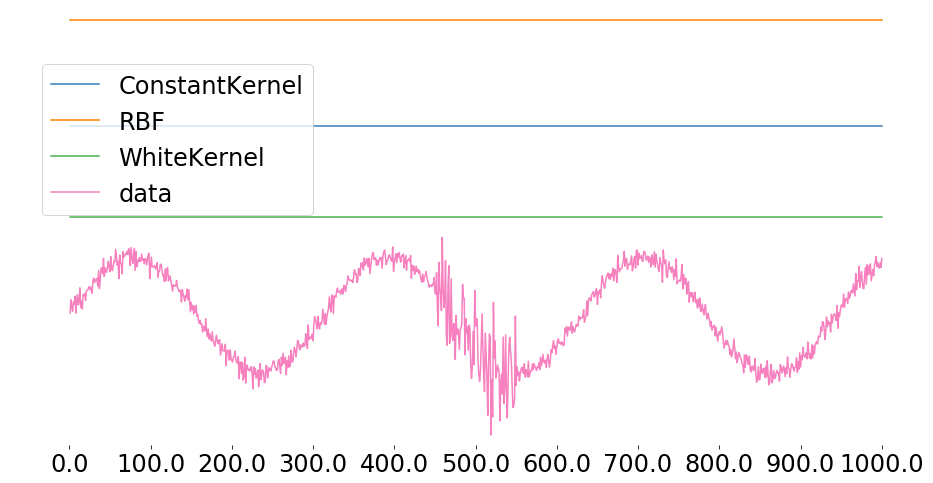

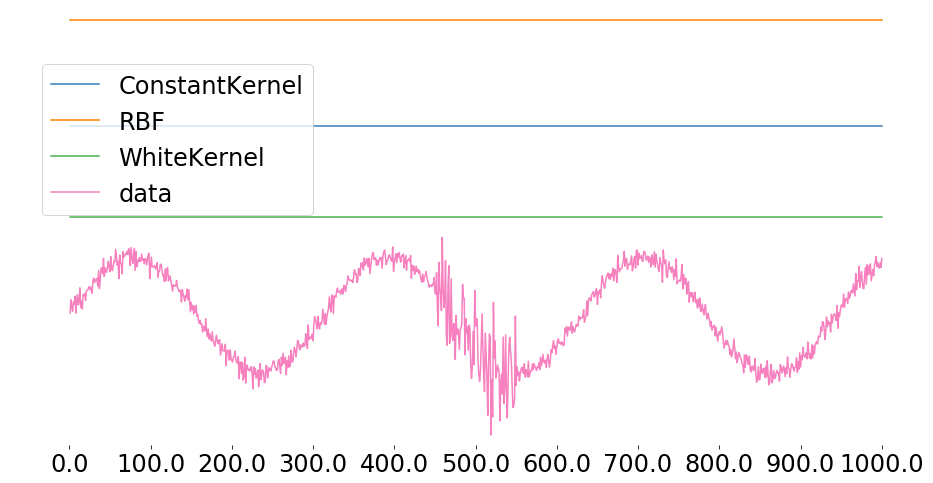

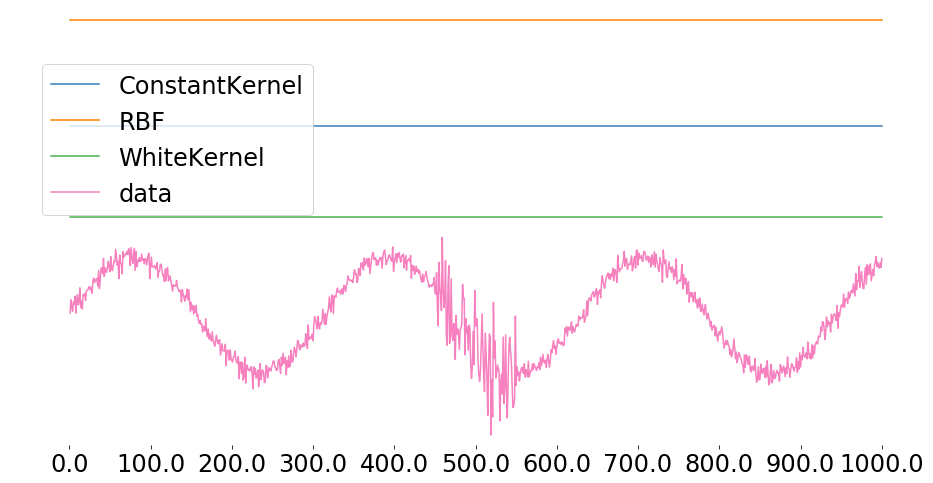

In [397]:
for i,frac in enumerate(FRACS):
    gpr_params = frac_gpr_paramses[i]
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    adjust_ax_labels(axs,(np.min(X)-1, np.max(X)),hz=1,n_ticks=11)
    artists = []
    colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for col in range(gpr_params.shape[1]):
        c = next(colors)
        ar = axs[0].plot(X, gpr_params[:,col],c=c)
        #axs[1].plot(X, opt_meanshifts[:,col],c=c)
        artists.append(ar[0])
    ar = axs[1].plot(X,y,c=next(colors))
    artists.append(ar[0])
    axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(exemplar_regressor.kernel_) if k.n_dims])) + ["data"],loc="lower left")
    plt.savefig(os.path.join(project_dir, "neighborbeta0_{:05d}_unnormalized.png".format(frac)), bbox_inches="tight")

In [296]:
np.exp(the_models[-1].kernel_.bounds)

array([[5.06580751e-01, 5.06580751e+01],
       [3.38354986e+00, 3.38354986e+02],
       [1.00000000e-05, 1.00000000e+05]])

In [337]:
soft_bound(the_models[-1].kernel_, the_models[-1].kernel_.theta, priors)

(-146.0279237229738, array([-4.94946212, -2.0911644 , 16.22299922]))

In [338]:
the_models[-1].kernel_.theta,the_models[0].kernel_.theta

(array([  2.33479841,   3.82245325, -25.36052819]),
 array([  1.91633192,   3.0793149 , -24.67134237]))

In [271]:
soft_bound(the_models[0].kernel_, the_models[-1].kernel_.theta, priors)

(0.035633381534782085, array([ 0.01904415,  0.00833174, -0.03216905]))

In [286]:
import importlib; importlib.reload(local_models.local_models)

<module 'local_models.local_models' from '/home/brown/python_packages/local_models/local_models/local_models.py'>

In [236]:
a = local_models.local_models.TriCubeKernel(5)

In [277]:
priors[0].bandwidth

array([2.80258509])

In [287]:
soft_bound(kernel, kernel.theta+np.log(9), priors)

(0.03376949053261374, array([0.00944673, 0.00944673, 0.00051416]))

In [197]:
np.exp(kernel.theta)

array([ 5.06580751, 33.83549859,  1.        ])

In [148]:
regressor = GPR(kernel=exemplar_regressor.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
gpr_models = local_models.local_models.LocalModels(regressor)
gpr_models.fit(X,y)
local_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
gpr_params = gpr_models.transform(X,r=local_kernel.support_radius()-1, weighted=True, kernel=local_kernel, neighbor_beta0s=False, batch_size=X.shape[0])

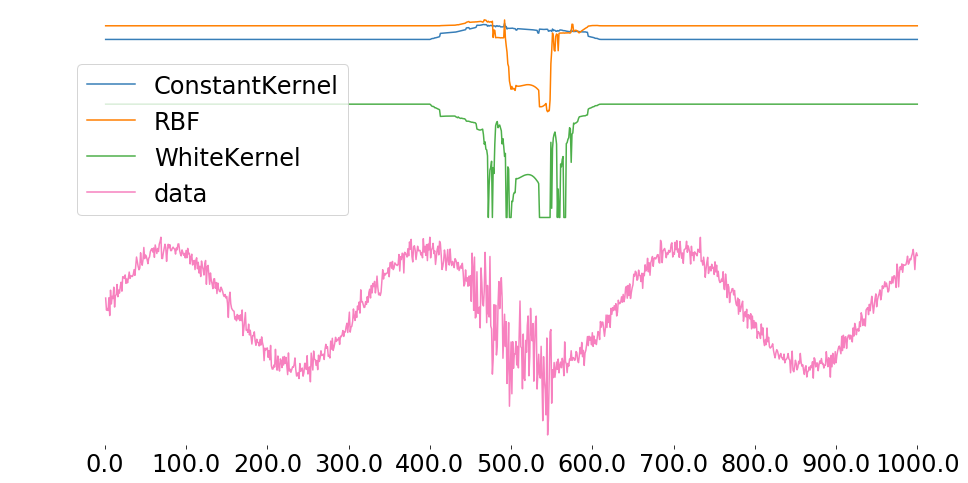

In [149]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,(np.min(X)-1, np.max(X)),hz=1,n_ticks=11)
artists = []
colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
for col in range(gpr_params.shape[1]):
    c = next(colors)
    ar = axs[0].plot(X, gpr_params[:,col],c=c)
    #axs[1].plot(X, opt_meanshifts[:,col],c=c)
    artists.append(ar[0])
ar = axs[1].plot(X,y,c=next(colors))
artists.append(ar[0])
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(exemplar_regressor.kernel_) if k.n_dims])) + ["data"],loc="lower left")
plt.savefig(os.path.join(project_dir, "fixedbeta0.png"))

In [152]:
regressor = GPR(kernel=exemplar_regressor.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
gpr_models = local_models.local_models.LocalModels(regressor)
gpr_models.fit(X,y)
local_kernel = local_models.local_models.UniformKernel(bandwidth=bandwidth)
gpr_params = gpr_models.transform(X,r=local_kernel.support_radius()-1, weighted=True, kernel=local_kernel, neighbor_beta0s=False, batch_size=X.shape[0])

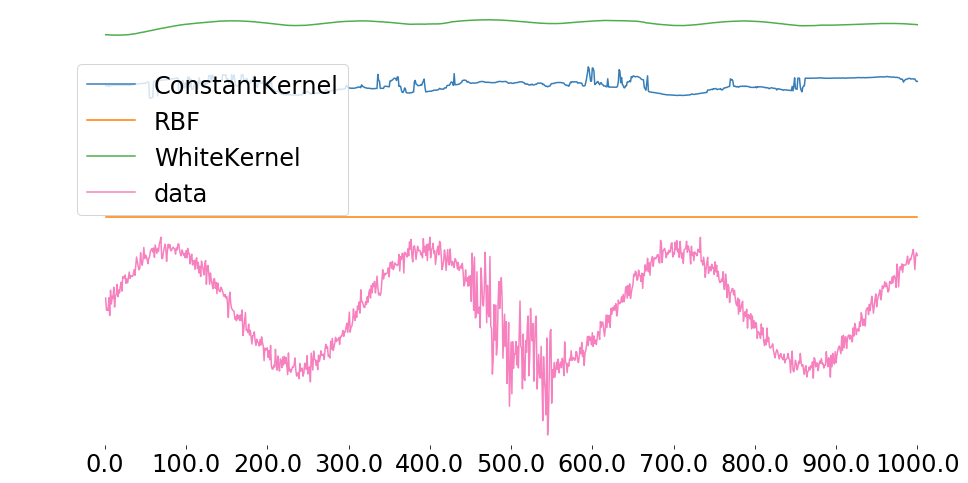

In [153]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,(np.min(X)-1, np.max(X)),hz=1,n_ticks=11)
artists = []
colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
for col in range(gpr_params.shape[1]):
    c = next(colors)
    ar = axs[0].plot(X, gpr_params[:,col],c=c)
    #axs[1].plot(X, opt_meanshifts[:,col],c=c)
    artists.append(ar[0])
ar = axs[1].plot(X,y,c=next(colors))
artists.append(ar[0])
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(exemplar_regressor.kernel_) if k.n_dims])) + ["data"],loc="lower left")
plt.show()
#plt.savefig(os.path.join(project_dir, "neighborbeta0_uniform.png"))

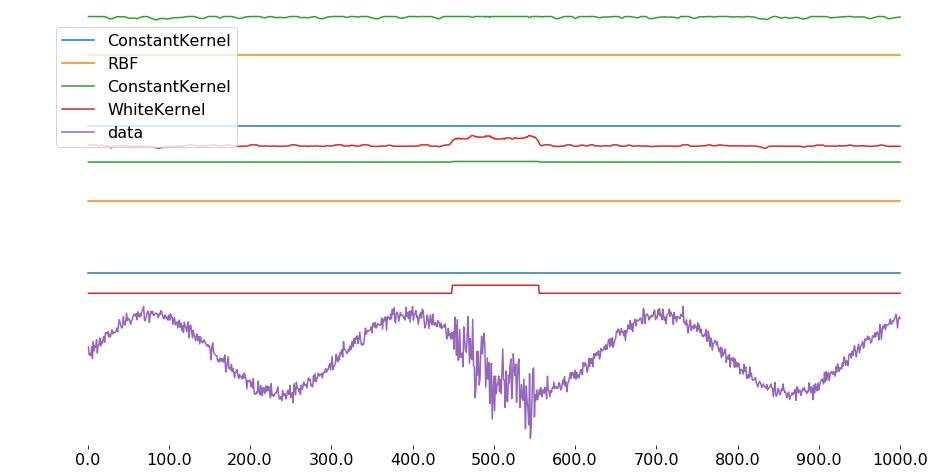

In [41]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,(np.min(X)-1, np.max(X)),hz=1,n_ticks=11)
artists = []
colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
for col in range(opt_gprs.shape[1]):
    c = next(colors)
    ar = axs[0].plot(X, opt_gprs[:,col],c=c)
    axs[1].plot(X, opt_meanshifts[:,col],c=c)
    artists.append(ar[0])
ar = axs[2].plot(X,y,c=next(colors))
artists.append(ar[0])
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])) + ["data"],loc="lower left")
plt.show()

## Variable Period

In [ ]:
X = np.linspace(1,1000,1000).reshape((-1,1))
XX = np.linspace(1,10000,10000).reshape((-1,1))
y = 10*np.sin(2*np.pi*X/50)
y[450:550] = 10*np.sin(2*np.pi*X[450:550]/15)
y[:,0] += np.random.normal(0,1,1000)

In [ ]:
plt.plot(X,y)
plt.show()

In [ ]:
kernel = np.sum((
    #gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,100]),
    #np.prod((
    #    gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,100]),
    #    gp.kernels.RBF(length_scale=10, length_scale_bounds=[1,10000])
    #)),
    np.prod((
        gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[1e-10,1e10]),
        #gp.kernels.DotProduct(sigma_0_bounds=[1e-10,1e-10]),
        #gp.kernels.RBF(length_scale=1000, length_scale_bounds=[1,10000000]), #This does NOT only have the effect of decay away from exact periodicity...
        gp.kernels.ExpSineSquared(length_scale=2, periodicity=50, length_scale_bounds=[1e-10,1e10], periodicity_bounds=[1e-10,1e10])
    )),
    # The optimizer REEEAAALLLY wants to skip over periodicity=50 (which is the "true" periodicity....)
    gp.kernels.WhiteKernel(noise_level=1.0, noise_level_bounds=[1e-10,1e10])
))

In [ ]:
initial_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400)

In [ ]:
initial_regressor.fit(X[:200],y[:200])

In [ ]:
initial_kernel = initial_regressor.kernel_

In [ ]:
initial_kernel

In [ ]:
regressor = GPR(kernel=initial_kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)

In [ ]:
bandwidth=120
lm_kernel = lm.TriCubeKernel(bandwidth=100)
gpr_models = lm.LocalModels(regressor)
gpr_models.fit(X,y)

In [ ]:
FRESH=True
dat_dir = os.path.join(project_dir, "dat_variable_period")
os.makedirs(dat_dir, exist_ok=1)

In [ ]:
parms = []
grid_seeds = np.mgrid[-1:6:7j,-1:6:7j]

In [ ]:
if FRESH:
    for i, grid_seed in enumerate(grid_seeds[len(parms):]):
        kernel = np.sum((
            np.prod((
                gp.kernels.ConstantKernel(constant_value=grid_seeds[0], constant_value_bounds="fixed"),
                gp.kernels.ExpSineSquared(length_scale=grid_seeds[1], periodicity=50, length_scale_bounds="fixed", periodicity_bounds=[1e-10,1e10])
            )),
            # The optimizer REEEAAALLLY wants to skip over periodicity=50 (which is the "true" periodicity....)
            gp.kernels.WhiteKernel(noise_level=np.exp(initial_kernel[-1]), noise_level_bounds="fixed")
        ))
        regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        gpr_models = local_models.local_models.LocalModels(regressor)
        gpr_models.fit(X,y)
        local_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
        gpr_params = gpr_models.transform(X,r=local_kernel.support_radius()-1, weighted=True, kernel=local_kernel, neighbor_beta0s=False, batch_size=X.shape[0])
        parms.append(gpr_params)

In [ ]:
for i,parm in enumerate(parms):
    fig, axs = plt_gpr_params(
        X,y,
        X,parm,
        [[450,550]],
        kernel,
        os.path.join(project_dir, 
        "variable_period_gpr_k{}_b{:07.02f}_c{:010.02f}_r{:010.02f}_w{:010.02f}.png".format(
            "_".join(list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims]))),
            bandwidth,
            grid_seeds[i,0],
            grid_seeds[i,1],
            1)),
        display=True
        )
    axs[0].set_title(str(grid_seeds[i]))

In [ ]:
plt_dir = os.path.join(project_dir, "plt_variable_period_{:02d}".format(RUN))
os.makedirs(plt_dir, exist_ok=1)

In [ ]:
%%capture
if FRESH:
    for i,bandwidth in enumerate(bandwidths):
        fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
        for col in range(parms[i].shape[1]):
            plt.plot(X, parms[i][:,col])
            plt.title("b_{:08.4f}".format(bandwidth))
        plt.savefig(os.path.join(plt_dir, "img_{:05d}.png".format(i)))
        clear(fig, axs)

In [ ]:
for col in range(parms[1].shape[1]):
    plt.plot(X,parms[1][:,col])
plt.show()

In [ ]:
X_more = np.linspace(0,2000,2000).reshape(-1,1)

In [ ]:
y_pred_0 = models[1][100].predict(X_more)

In [ ]:
y_pred_1 = models[1][500].predict(X_more)

In [ ]:
plt.plot(models[1][500].X_train_, models[1][500].y_train_)
plt.show()

In [ ]:
np.e**models[1][500].kernel_.theta

In [ ]:
np.e**models[1][100].kernel_.theta

In [ ]:
plt.plot(X,y)
plt.show()

In [ ]:
plt.plot(X_more,y_pred_0)
plt.show()

In [ ]:
plt.plot(X_more,y_pred_1)
plt.show()

In [ ]:
#legend = []
#kparms = kernel.get_params()
#for k in sorted(kparms):
#    if isinstance(kparms[k], (int, float)):
#        legend.append(k)
legend = ["$C_1$", "$C_2$", "$L_1$", "$C_3$", "$L_2$", "$L_3$", "$P_1$", "$C_4$", "$W_1$"]
for col in range(parms[2].shape[1]):
    plt.plot(X,parms[2][:,col])
plt.legend(legend, loc="upper left")
plt.show()

In [ ]:
legend = ["$C_1$", "$C_2$", "$L_1$", "$C_3$", "$L_2$", "$L_3$", "$P_1$", "$C_4$", "$W_1$"]
plt.plot(X,parms[2][:,6])
#plt.legend(legend, loc="upper left")
plt.show()

In [ ]:
clusterer = sklearn.cluster.MeanShift(bandwidth=2, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=1)

In [ ]:
clusterer.fit(parms[1])

In [ ]:
clusterer.cluster_centers_

In [ ]:
clust_pred = clusterer.predict(parms[1])

In [ ]:
plt.plot(X, clust_pred)
plt.show()

In [ ]:
from cycler import cycler
a = mpl.rcParams['axes.prop_cycle'].by_key()['color']
a.pop(2)
mpl.rcParams['axes.prop_cycle'] = cycler(color=a)

In [ ]:
fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(X,y)
axes[0].axvline(x=450,color='k',linestyle='--')
axes[0].axvline(x=550,color='k',linestyle='--')

legend = ["$C_1$", "$C_2$", "$L_1$", "$C_3$", "$L_2$", "$L_3$", "$P_1$", "$C_4$", "$W_1$"]
for col in range(parms[1].shape[1]):
    axes[1].plot(X,parms[1][:,col])
axes[1].legend(legend, loc="upper right")

changes = [i for i in range(len(clust_pred)-1) if (clust_pred[i+1] - clust_pred[i])]
for change in changes:
    axes[1].axvline(x=change,color='k',linestyle='--')

fig.subplots_adjust(hspace=0)
for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


fig.savefig(os.path.join(project_dir, "variable_period_clustering_b_068.png"), bbox_inches='tight')
plt.show()

## Variable rates of change

In [ ]:
y = 1e-20*(X-20)*(X-200)*(X-300)*(X-480)*(X-520)*(X-700)*(X-800)*(X-980)

In [ ]:
plt.plot(X,y)
plt.show()